In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Heston Model Basic Implementation <span style="font-size: 60%;">(Parameters set by hand)</span>

In [3]:
def get_initial_asset_price():
    while True:
        S = input('Enter the initial asset price : ')
        try:
            initial_asset_price = int(S)
            return initial_asset_price
        except ValueError:
            print("Invalid number type. Please enter an integer number.")

def get_initial_volatility():
    while True:
        vol = input('Enter the Volatility (between 0 and 1) : ')
        try:
            volatility = float(vol)
            if 0 <= volatility <= 1:
                return volatility
            else:
                print("Invalid value. Please enter a number between 0 and 1.")
        except ValueError:
            print("Invalid number type. Please enter a decimal number between 0 and 1.")

def get_long_term_variance():
    while True:
        var_long = input('Enter the Long Term Variance (between 0 and 1) : ')
        try:
            var_long_term = float(var_long)
            if 0 <= var_long_term <= 1:
                return var_long_term
            else:
                print("Invalid value. Please enter a number between 0 and 1.")
        except ValueError:
            print("Invalid number type. Please enter a decimal number between 0 and 1.")
            
def get_rate_of_reversion():
    while True:
        rate = input('Enter the rate of reversion of variance (between -1 and 1): ')
        try:
            rate_of_reversion = float(rate)
            if -1 <= rate_of_reversion <= 1:
                return rate_of_reversion
            else:
                print("Invalid value. Please enter a number between -1 and 1.")
        except ValueError:
            print("Invalid number type. Please enter a decimal number between -1 and 1.")

def get_vol_of_vol():
    while True:
        v_o_v = input('Enter the Volatility of Volatility (between 0 and 1): ')
        try:
            vol_of_vol = float(v_o_v)
            if 0 <= vol_of_vol <= 1:
                return vol_of_vol
            else:
                print("Invalid value. Please enter a number between 0 and 1.")
        except ValueError:
            print("Invalid number type. Please enter a decimal number between 0 and 1.")

def get_correlation():
    while True:
        cor = input('Enter the correlation between the two processes (between -1 and 1): ')
        try:
            correlation = float(cor)
            if -1 <= correlation <= 1:
                return correlation
            else:
                print("Invalid value. Please enter a number between -1 and 1.")
        except ValueError:
            print("Invalid number type. Please enter a decimal number between -1 and 1.")

def get_rf():
    while True:
        rate = input('Enter the Risk-Free rate (between 0 and 1): ')
        try:
            rate = float(rate)
            if 0 <= rate <= 1:
                return rate
            else:
                print("Invalid value. Please enter a number between 0 and 1.")
        except ValueError:
            print("Invalid number type. Please enter a decimal number between 0 and 1.")

def get_maturity():
    while True:
        M = input('Enter the Maturity (in years): ')
        try:
            maturity = float(M)
            if maturity > 0:
                return maturity
            else:
                print("Invalid value. Please enter a positive number.")
        except ValueError:
            print("Invalid number type. Please enter a valid number.")

def get_time_step():
    while True:
        steps = input('Enter the number of time steps (between 0 and 1000): ')
        try:
            steps = int(steps)
            if 0 <= steps <= 1000:
                return steps
            else:
                print("Invalid value. Please enter a number between 0 and 1000.")
        except ValueError:
            print("Invalid number type. Please enter a integer number between 0 and 1000.")
    
def get_paths():
    while True:
        paths = input('Enter the number of paths (between 0 and 10000): ')
        try:
            paths = int(paths)
            if 0 <= paths <= 10000:
                return paths
            else:
                print("Invalid value. Please enter a number between 0 and 10000.")
        except ValueError:
            print("Invalid number type. Please enter a integer number between 0 and 10000.")

In [4]:
S0 = get_initial_asset_price()  
v0 = get_initial_volatility()      
theta = get_long_term_variance()   
kappa = get_rate_of_reversion()  
sigma_v = get_vol_of_vol()  
rho = get_correlation()     
r = get_rf()       
T = get_maturity()        
N = get_time_step()      
M = get_paths()  
dt=T/N   

In [5]:
print("Parameter Values:")
print("---------------------------------------")
print(f"Initial Asset Price (S0):     {S0} $")
print(f"Initial Volatility (v0):      {v0*100} %")
print(f"Long-term Variance (theta):   {theta*100} %")
print(f"Rate of Reversion (kappa):    {kappa*100} %")
print(f"Volatility of Volatility:     {sigma_v*100} %")
print(f"Correlation (rho):            {rho}")
print(f"Risk-free Interest Rate (r):  {r*100} %")
print(f"Maturity (T):                 {T} years")
print(f"Number of Time Steps (N):     {N}")
print(f"Number of Paths (M):          {M}")
print("---------------------------------------")

Parameter Values:
---------------------------------------
Initial Asset Price (S0):     100 $
Initial Volatility (v0):      4.0 %
Long-term Variance (theta):   4.0 %
Rate of Reversion (kappa):    50.0 %
Volatility of Volatility:     3.0 %
Correlation (rho):            -0.7
Risk-free Interest Rate (r):  5.0 %
Maturity (T):                 1.0 years
Number of Time Steps (N):     1000
Number of Paths (M):          10000
---------------------------------------


<ins>Generation of Winer processes.</ins>

To generate Wiener processes we need to use the <ins>Euler Scheme.
</ins>

The Euler Scheme is a numerical method for solving stochastic differential equations, it is a discrete approximation of the solution of a stochastic differential equation.

The stochastic differential equation for the asset price $ S_t $ in the Heston model is:

$$
\boxed{dS_t = \mu S_t \, dt + \sqrt{v_t} S_t \, dW_t^S}
$$

And the stochastic differential equation for the variance $ v_t $ (volatility) is:

$$ 
\boxed{dv_t = \kappa (\theta - v_t) \, dt + \sigma \sqrt{v_t} \, dW_t^v}
$$


All parameters are detailed in the Readme.

<br/>

The Euler Scheme is construct like that :

$$
\ln \hat{X}(t + \Delta) = \ln \hat{X}(t) + (r - \frac{1}{2}\hat{V}(t)^+)  \Delta + \sqrt{\hat{V}(t)^+ } Z_X \sqrt{\Delta}
$$

$$
\hat{V}(t + \Delta) = \hat{V}(t) + \kappa (\theta - \hat{V}(t)^+ ) \Delta + \epsilon \sqrt{\hat{V}(t)^+ } Z_V \sqrt{\Delta}
$$

In these formulas we got $\hat{V}(t)^+$ because with the basic Euler Scheme , an immediate problem is that the discrete process for $V$ can become negative with non-zero probability, which in turn would make computation of $\sqrt{\hat{V}(t)}$ impossible and cause the time-stepping scheme to fail.

We got : 

$$
Z_V = \Phi^{-1}(U_1)
$$
and 
$$
Z_X = \rho Z_V + \sqrt{1 - \rho^2} \Phi^{-1}(U_2)
$$

with $U_1$ and $U_2$ $\sim U(0, 1)$ .

<br/>

For us $Z_V$ will be $W1$ and $Z_X$ will be $W2$ in all the project.

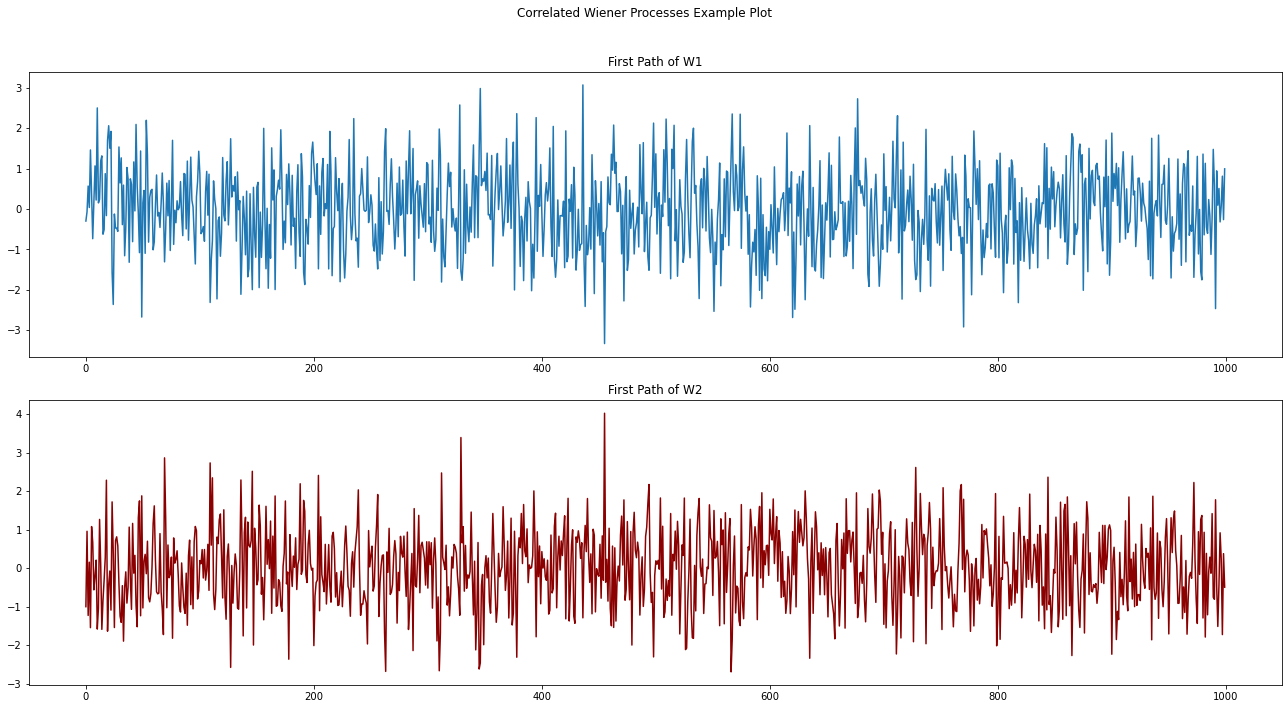

In [20]:
def generate_Wiener_correlated(time_step,paths,cor) : 
    """
    Generates two correlated Wiener processes.

    Parameters:
    - T (float): Total time (or maturity) of the process.
    - time_step (int): Number of time steps.
    - paths (int): Number of paths (simulations).
    - cor (float): Desired correlation coefficient between W1 and W2.

    Returns:
    - W1 (ndarray): Array of shape (time_step, paths) containing increments of the first Wiener process.
    - W2 (ndarray): Array of shape (time_step, paths) containing increments of the second Wiener process,
                    adjusted to have correlation 'cor' with W1.
    """
    W1=np.random.randn(time_step,paths)
    # W2=np.random.randn(time_step,paths) It's not good to do this because W1 and W2 will not be correlated
    W2=cor*W1+np.sqrt(1-cor**2)*np.random.randn(time_step,paths)
    return W1,W2

W1,W2=generate_Wiener_correlated(N,M,rho)


fig, ax = plt.subplots(2, 1, figsize=(18, 10))  
ax[0].plot(W1[:, 0]) 
ax[0].set_title('First Path of W1')

ax[1].plot(W2[:, 0],color='darkred')  
ax[1].set_title('First Path of W2')

fig.suptitle('Correlated Wiener Processes Example Plot')
plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

We got that from Euler Scheme : 

The Euler Scheme is construct like that :


$$
\ln \hat{X}(t + \Delta) = \ln \hat{X}(t) + (r - \frac{1}{2} \hat{V}(t)^+) \Delta + \sqrt{\hat{V}(t)^+ } Z_X \sqrt{\Delta}
$$

$$
\hat{V}(t + \Delta) = \hat{V}(t) + \kappa (\theta - \hat{V}(t)^+ ) \Delta + \epsilon \sqrt{\hat{V}(t)^+ } Z_V \sqrt{\Delta}
$$

This implies that  : 

$$
\boxed{\hat{X}(t + \Delta) = \hat{X}(t) * \exp ((r - \frac{1}{2} \hat{V}(t)^+) \Delta + \sqrt{\hat{V}(t)^+ } Z_X \sqrt{\Delta})}
$$

$$
\boxed{\hat{V}(t + \Delta) = \hat{V}(t) + \kappa (\theta - \hat{V}(t)^+ ) \Delta + \epsilon \sqrt{\hat{V}(t)^+ } Z_V \sqrt{\Delta}}
$$

In [39]:
def Euler_Scheme_Heston_Model(W1,W2,kappa,theta,dt,sigma_v,N,M,Price,volatility) : 
    for i in range(1, N):
        volatility[i] = volatility[i-1] + kappa * (theta - volatility[i-1]) * dt + sigma_v * np.sqrt(volatility[i-1] * dt) * W1[i-1]
        Price[i] = Price[i-1] * np.exp((r - 0.5 * volatility[i-1]) * dt + np.sqrt(volatility[i-1] * dt) * W2[i-1])
    return Price,volatility

It exists others scheme to compute prices and volatility predictions.

One of them is the <ins>Kahl-Jackel Scheme </ins> which is construct like that : 

$$
\ln \hat{X}(t + \Delta) = \ln \hat{X}(t) + \frac{\Delta}{4} (\hat{V}(t+\Delta) + \hat{V}(t)) + \rho \sqrt{\hat{V}(t)} Z_V \sqrt{\Delta} + \frac{1}{2} (\sqrt {\hat{V}(t+\Delta)}+ \sqrt{\hat{V}(t)})(Z_X\sqrt{\Delta}-\rho Z_V \sqrt{\Delta})+\frac{1}{4} \epsilon \rho \Delta (Z_V^2 -1)
$$

$$
\hat{V}(t + \Delta) = \frac{\hat{V}(t) + \kappa \theta \Delta + \epsilon \sqrt{\hat{V}(t)} Z_V \sqrt{\Delta} + \frac{1}{4} \epsilon ^2 \Delta (Z_V^2 -1)}{1+ \kappa \Delta}
$$

If we want $\hat{X}(t + \Delta)$ and not $\ln \hat{X}(t + \Delta)$ we need to apply (like we did to Euler formulas) an $\exp$. 

By applying this, the formulas became : 

$$
\boxed{\hat{X}(t + \Delta) = \hat{X}(t) * \exp (\frac{\Delta}{4} (\hat{V}(t+\Delta) + \hat{V}(t)) + \rho \sqrt{\hat{V}(t)} Z_V \sqrt{\Delta} + \frac{1}{2} (\sqrt {\hat{V}(t+\Delta)}+ \sqrt{\hat{V}(t)})(Z_X\sqrt{\Delta}-\rho Z_V \sqrt{\Delta})+\frac{1}{4} \epsilon \rho \Delta (Z_V^2 -1)) }
$$

$$
\boxed{\hat{V}(t + \Delta) = \frac{\hat{V}(t) + \kappa \theta \Delta + \epsilon \sqrt{\hat{V}(t)} Z_V \sqrt{\Delta} + \frac{1}{4} \epsilon ^2 \Delta (Z_V^2 -1)}{1+ \kappa \Delta}}
$$


In [67]:
def  Kahl_Jackel_Scheme_Heston_Model(W1,W2,kappa,theta,dt,rho,sigma_v,N,M,Price,volatility) : 
    sqrt_dt = np.sqrt(dt)
    for i in range(1, N):
        value_vol=(volatility[i-1] + (kappa * theta * dt) + (sigma_v * np.sqrt(volatility[i-1] * dt) * W1[i-1]) + ((1/4) * sigma_v**2 * dt *(W1[i-1]**2 - 1)))/(1+kappa*dt)
        volatility[i] = value_vol
        vol_term = np.sqrt(value_vol + volatility[i-1])        
        term1 = (dt / 4) * (value_vol + volatility[i-1])
        term2 = rho * np.sqrt(volatility[i-1] * dt) * W1[i-1]
        term3 = 0.5 * (np.sqrt(value_vol) + vol_term) * ((W2[i-1] * sqrt_dt) - (rho * W1[i-1] * sqrt_dt))
        term4 = 0.25 * sigma_v * rho * dt * (W1[i-1]**2 - 1)
        
        Price[i] = Price[i-1] * np.exp(-term1 + term2 - term3 + term4)
    return Price,volatility

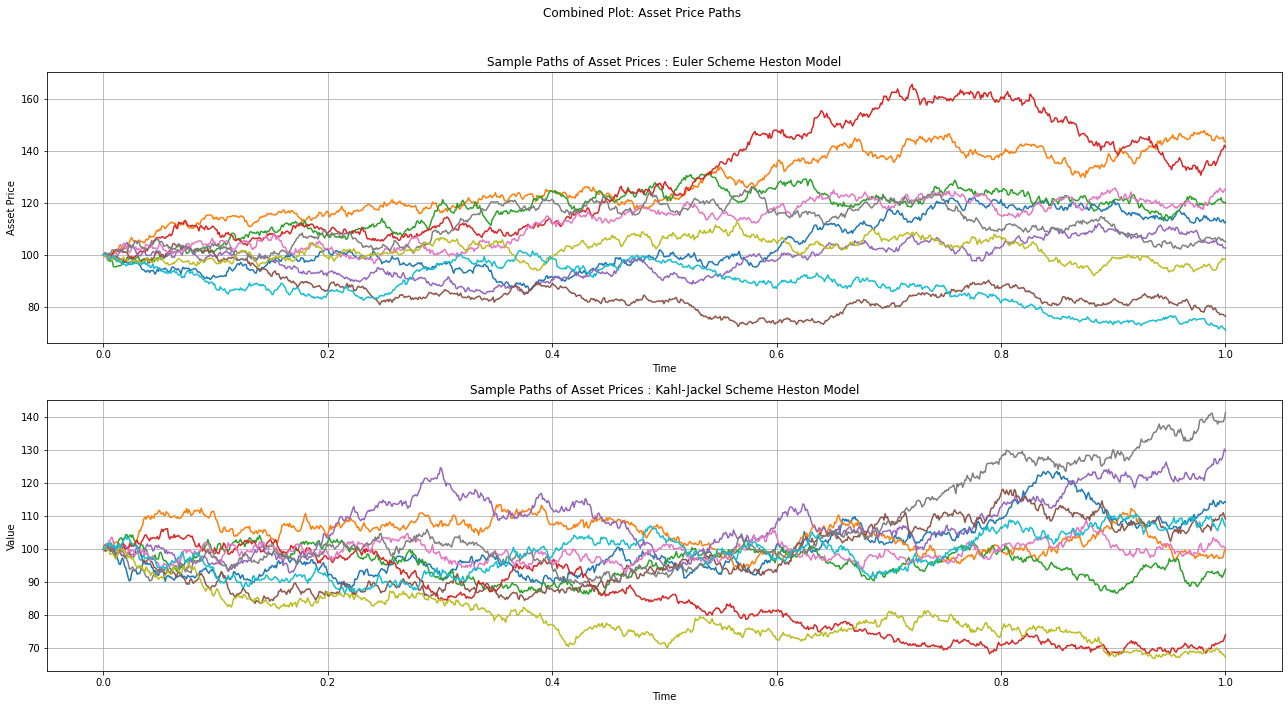

In [68]:
S_euler = np.zeros((N, M))
v_euler = np.zeros((N, M))
S_Kahl = np.zeros((N, M))
v_Kahl = np.zeros((N, M))

S_euler[0] = S0
v_euler[0] = v0
S_Kahl[0] = S0
v_Kahl[0] = v0

S_euler,v_euler=Euler_Scheme_Heston_Model(W1,W2,kappa,theta,dt,sigma_v,N,M,S_euler,v_euler)
S_Kahl,v_Kahl=Kahl_Jackel_Scheme_Heston_Model(W1,W2,kappa,theta,dt,rho,sigma_v,N,M,S_Kahl,v_Kahl)

fig, ax = plt.subplots(2, 1, figsize=(18, 10))

for i in range(10):
    ax[0].plot(np.linspace(0, T, N), S_euler[:, i])

ax[0].set_xlabel('Time')
ax[0].set_ylabel('Asset Price')
ax[0].set_title('Sample Paths of Asset Prices : Euler Scheme Heston Model')
ax[0].grid(True)

for i in range(10):
    ax[1].plot(np.linspace(0, T, N), S_Kahl[:, i])

ax[1].set_xlabel('Time')
ax[1].set_ylabel('Value')
ax[1].set_title('Sample Paths of Asset Prices : Kahl-Jackel Scheme Heston Model')
ax[1].grid(True)

fig.suptitle('Combined Plot: Asset Price Paths ')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()